<a href="https://colab.research.google.com/github/Kirankumarpetlu/Brain-Tumor-Detection/blob/main/BrainCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from PIL import Image

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:

import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm


In [16]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels (RGB) for ResNet
    transforms.ToTensor(),              # Convert to tensor
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1] range
])


In [17]:

data_path ='/content/drive/MyDrive/BrainTumor/archive (13)/brain_tumor_dataset'
dataset = ImageFolder(root=data_path, transform=transform)
print("Classes:", dataset.classes)

Classes: ['no', 'yes']


In [18]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [19]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [20]:
# Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze earlier layers (optional, for faster training)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output for 2 classes: ['no', 'yes']

# Move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [22]:
epochs = 14 # You can increase this later for better accuracy

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

    print(f"✅ Epoch {epoch+1} complete - Loss: {running_loss:.4f} - Accuracy: {100 * correct / total:.2f}%")


Epoch [1/14]: 100%|██████████| 7/7 [01:12<00:00, 10.34s/it, acc=67.8, loss=0.499]


✅ Epoch 1 complete - Loss: 4.1339 - Accuracy: 67.82%


Epoch [2/14]: 100%|██████████| 7/7 [00:27<00:00,  3.92s/it, acc=77.7, loss=0.397]


✅ Epoch 2 complete - Loss: 3.3324 - Accuracy: 77.72%


Epoch [3/14]: 100%|██████████| 7/7 [00:26<00:00,  3.75s/it, acc=86.6, loss=0.31]


✅ Epoch 3 complete - Loss: 2.8913 - Accuracy: 86.63%


Epoch [4/14]: 100%|██████████| 7/7 [00:25<00:00,  3.71s/it, acc=83.7, loss=0.513]


✅ Epoch 4 complete - Loss: 2.7750 - Accuracy: 83.66%


Epoch [5/14]: 100%|██████████| 7/7 [00:25<00:00,  3.65s/it, acc=87.1, loss=0.384]


✅ Epoch 5 complete - Loss: 2.6171 - Accuracy: 87.13%


Epoch [6/14]: 100%|██████████| 7/7 [00:28<00:00,  4.04s/it, acc=85.6, loss=0.286]


✅ Epoch 6 complete - Loss: 2.1751 - Accuracy: 85.64%


Epoch [7/14]: 100%|██████████| 7/7 [00:26<00:00,  3.77s/it, acc=88.1, loss=0.211]


✅ Epoch 7 complete - Loss: 2.0904 - Accuracy: 88.12%


Epoch [8/14]: 100%|██████████| 7/7 [00:26<00:00,  3.82s/it, acc=88.6, loss=0.535]


✅ Epoch 8 complete - Loss: 2.3320 - Accuracy: 88.61%


Epoch [9/14]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it, acc=88.1, loss=0.277]


✅ Epoch 9 complete - Loss: 2.0117 - Accuracy: 88.12%


Epoch [10/14]: 100%|██████████| 7/7 [00:26<00:00,  3.74s/it, acc=92.6, loss=0.326]


✅ Epoch 10 complete - Loss: 1.7835 - Accuracy: 92.57%


Epoch [11/14]: 100%|██████████| 7/7 [00:26<00:00,  3.76s/it, acc=92.6, loss=0.172]


✅ Epoch 11 complete - Loss: 1.7377 - Accuracy: 92.57%


Epoch [12/14]: 100%|██████████| 7/7 [00:26<00:00,  3.75s/it, acc=93.6, loss=0.234]


✅ Epoch 12 complete - Loss: 1.6672 - Accuracy: 93.56%


Epoch [13/14]: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it, acc=90.1, loss=0.346]


✅ Epoch 13 complete - Loss: 1.8768 - Accuracy: 90.10%


Epoch [14/14]: 100%|██████████| 7/7 [00:25<00:00,  3.64s/it, acc=90.6, loss=0.327]

✅ Epoch 14 complete - Loss: 2.0044 - Accuracy: 90.59%


In [23]:
# Save model to file (after final epoch)
torch.save(model.state_dict(), "brain_tumor_resnet18.pth")
print(" Model saved ")


 Model saved 


In [25]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Target the final convolutional layer of ResNet18
target_layers = [model.layer4[-1]]

# Create the GradCAM object
cam = GradCAM(model=model, target_layers=target_layers)

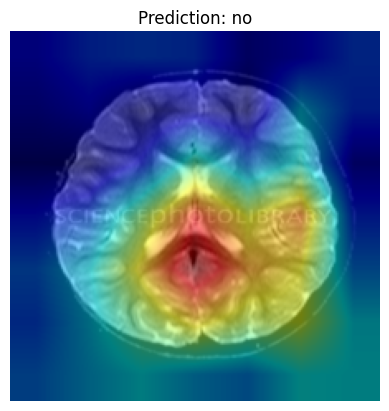

In [27]:
# Select an image from validation dataset
image_tensor, label = val_dataset[0]  # Change index to test other images
input_tensor = image_tensor.unsqueeze(0).to(device)

# Predict class
model.eval()
output = model(input_tensor)
_, pred_class = torch.max(output, 1)
predicted_label = dataset.classes[pred_class.item()]

# Create Grad-CAM target
targets = [ClassifierOutputTarget(pred_class.item())]

# Ensure gradients are computed for the target layer
for param in target_layers[0].parameters():
    param.requires_grad = True

# Generate Grad-CAM heatmap
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

# Set requires_grad back to original state if needed (assuming it was False)
for param in target_layers[0].parameters():
    param.requires_grad = False


# Prepare image for overlay
img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
img_np = (img_np * 0.5) + 0.5  # Unnormalize to [0, 1]

# Overlay heatmap
cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# Plot result
plt.imshow(cam_image)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Predicted Class: no


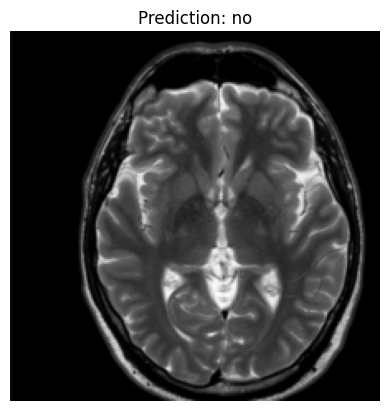

In [28]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set image path (your exact image)
image_path = "/content/drive/MyDrive/BrainTumor/Screenshot 2025-06-28 182535.png"

# Load and preprocess image
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load image in grayscale
image = Image.open(image_path).convert('L')

# Apply same transforms as used in training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Prepare image tensor
image_tensor = transform(image).unsqueeze(0).to(device)

#  Predict using trained model
model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

#  Show prediction
print(f"Predicted Class: {dataset.classes[predicted_class.item()]}")

# Display image with predicted class
img_display = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
img_display = (img_display * 0.5) + 0.5  # Unnormalize

plt.imshow(img_display)
plt.title(f"Prediction: {dataset.classes[predicted_class.item()]}")
plt.axis('off')
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Predicted Class: yes


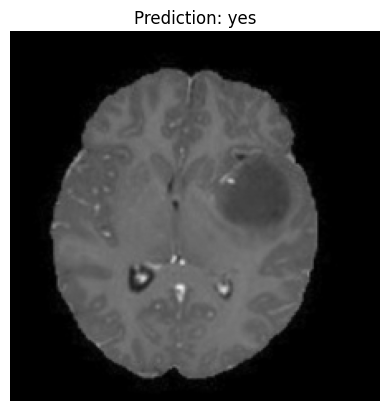

In [29]:
from google.colab import drive
drive.mount('/content/drive')

image_path = "/content/drive/MyDrive/BrainTumor/Screenshot 2025-06-28 214935.png"

from PIL import Image
from torchvision import transforms, models
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze earlier layers (optional, for faster training)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output for 2 classes: ['no', 'yes']

# Move model to GPU (if available)
model = model.to(device)

# Load the saved model weights
model.load_state_dict(torch.load("brain_tumor_resnet18.pth", map_location=device))


image = Image.open(image_path).convert('L')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Prepare image tensor
image_tensor = transform(image).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

# Show prediction
print(f" Predicted Class: {dataset.classes[predicted_class.item()]}")

#  Display image with predicted class
img_display = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
img_display = (img_display * 0.5) + 0.5  # Unnormalize

plt.imshow(img_display)
plt.title(f"Prediction: {dataset.classes[predicted_class.item()]}")
plt.axis('off')
plt.show()

In [10]:
data_path ='/content/drive/MyDrive/BrainTumor/archive (13)/brain_tumor_dataset'
dataset = ImageFolder(root=data_path, transform=transform)
print("Classes:", dataset.classes)

Classes: ['no', 'yes']


In [30]:
from torchvision import models
import torch.nn as nn
import torch

# Load base model structure
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Load saved weights
model.load_state_dict(torch.load("/content/brain_tumor_resnet18.pth", map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.eval()



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Predicted Class: yes


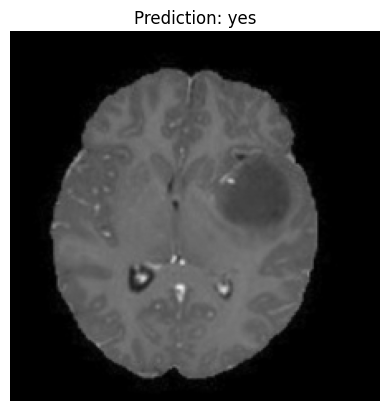

In [33]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#  Step 1: Setup
image_path = "/content/drive/MyDrive/BrainTumor/Screenshot 2025-06-28 214935.png"

from PIL import Image
from torchvision import transforms, models
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Step 2: Load model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model = model.to(device)

# Load trained weights
model.load_state_dict(torch.load("/content/brain_tumor_resnet18.pth", map_location=device))
model.eval()

#  Step 3: Load and preprocess the image
image = Image.open(image_path).convert('L')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

image_tensor = transform(image).unsqueeze(0).to(device)

#  Step 4: Predict
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_class = torch.max(output, 1)

class_names = ['no', 'yes']
print(f"✅ Predicted Class: {class_names[predicted_class.item()]}")

#  Step 5: Show image
img_display = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
img_display = (img_display * 0.5) + 0.5
plt.imshow(img_display)
plt.title(f"Prediction: {class_names[predicted_class.item()]}")
plt.axis('off')
plt.show()


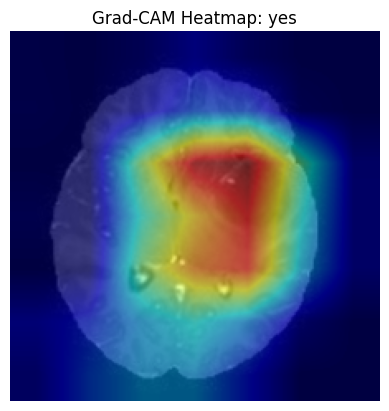

In [36]:

!pip install -q grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np

# Set the last conv layer of ResNet18
target_layers = [model.layer4[-1]]

# Create Grad-CAM object
cam = GradCAM(model=model, target_layers=target_layers)

# Define target class
targets = [ClassifierOutputTarget(predicted_class.item())]

# Ensure gradients are computed for the target layer
for param in target_layers[0].parameters():
    param.requires_grad = True

# Generate heatmap
grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0, :]

# Set requires_grad back to original state if needed (assuming it was False)
for param in target_layers[0].parameters():
    param.requires_grad = False

# Overlay heatmap on image
cam_image = show_cam_on_image(img_display, grayscale_cam, use_rgb=True)

# Display result
plt.imshow(cam_image)
plt.title(f"Grad-CAM Heatmap: {class_names[predicted_class.item()]}")
plt.axis('off')
plt.show()